In [3]:
import numpy as np
import scipy as sp
import pandas as pd
import scipy
import scipy.stats
import math
import random
import matplotlib.pyplot as plt
import pickle

### Data Generation

In [926]:
class Model:
    # missing is the probability of an observation missing, default to zero 
    def __init__(self, time_length, missing=0):
        self.T = time_length
        self.num_treatments = 1
        self.X = np.zeros((self.T, self.num_treatments))
        self.A = np.array([[-.5], [-.7]]) # the coefficients a_j's stored in a matrix
        self.b = np.array([.8])
        self.c = np.array([1])
        # noise are the variance, not standard deviation
        self.noise_0 = .01
        self.noise_1 = .01
        self.noise_2 = .001
        self.init_z = 6
        self.z = np.zeros(time_length)
        self.y = np.zeros(time_length)
        self.pi = np.zeros(time_length)
        self.missing = missing
        
    def set_X(self):
        for t in range(self.T):
            self.X[t, :] = np.random.binomial(n=1, p=0.2, size=1)# np.random.randint(2, size = self.num_treatments)

    def transition(self, prev):
        z = np.random.normal(prev, np.sqrt(self.noise_1), 1)
        return z

    def emission(self, z, t):
        treatment_effect = 0
        for j in range(np.shape(self.A)[0]):
            if t-1 >= j:
                treatment_effect += np.dot(self.A[j, :], self.X[t-1-j, :])
        pi = treatment_effect + np.dot(self.b, self.c) # total added effect
        prob = np.random.uniform(0, 1, 1)
        if prob < self.missing and t > 0:
            y = np.nan
        else:
            mean = z + pi
            y = np.random.normal(mean, np.sqrt(self.noise_2), 1)
        return y, pi
    
    def pct_missing(self):
        pct = np.shape(np.where(np.isnan(self.y))[0])[0]/self.T*100
        print('missing {}% of observations'.format(pct))
        
    def run_simulation(self):
        self.set_X()
        self.z[0] = np.random.normal(self.init_z, np.sqrt(self.noise_0), 1)
        self.y[0], self.pi[0] = self.emission(self.z[0], 0)
        for t in range(1, self.T):
            self.z[t] = self.transition(self.z[t-1])
            self.y[t], self.pi[t] = self.emission(self.z[t], t)
    
    def plot_trajectory(self):
        times = list(range(self.T))
        fig = plt.figure()
        plt.plot(times, self.y, label = 'observed')
        plt.plot(times, self.z, label = 'counterfactual')
        for t in np.nonzero(self.X)[0]:
            plt.axvline(x=t, color='g', linestyle='--')
        plt.xlabel('time (hr)')
        plt.ylabel('INR')
        plt.title('Simulated trajectory')
        plt.legend()
        fig.set_figheight(8)
        fig.set_figwidth(15)
        plt.show()

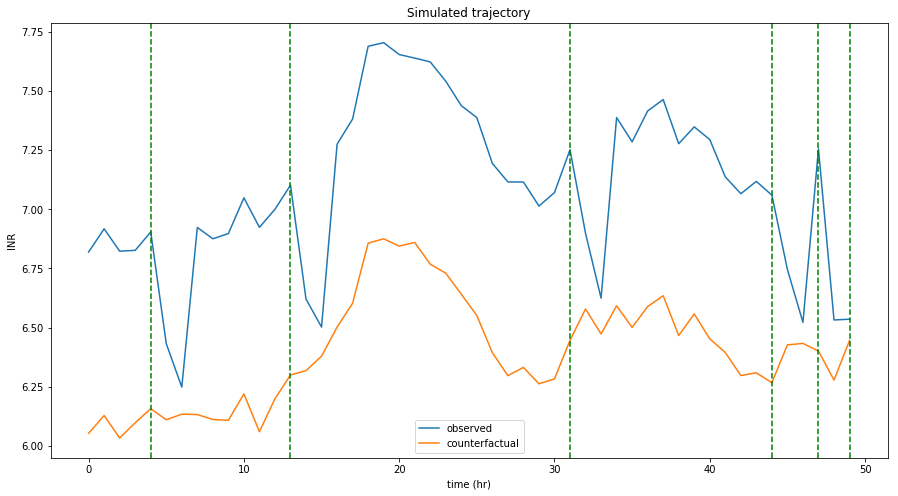

missing 0.0% of observations


In [927]:
model = Model(50, 0.0)
model.run_simulation()
model.plot_trajectory()
model.pct_missing()

### EM

In [928]:
class EM:
    def __init__(self, y, X, c, N, M, K, J):
        # Store observed sequence, treatments, chronic conditions
        self.T = np.shape(y)[0] # length of the observed sequence
        self.y = y
        self.X = X # treatment matrix
        self.c = c # chronic conditions
        self.Q = np.zeros((self.T, K)) # interaction term
        
        # Fixed model parameters
        self.N = N # number of treatments
        self.M = M # number of chronic conditions
        self.K = K # number of interaction terms modeled
        self.J = J # number of past treatment effects to be considered
        
        # Model Parameters to be estimated
        self.A = np.random.randn(J, N)*0.01 # np.zeros((J, N)) # coefficients a_j's
        self.b = np.random.randn(M)*0.01 # np.zeros(M)
        self.d = np.zeros(K)
        self.sigma_1 = .05
        self.sigma_2 = .005
        self.sigma_0 = .01 # initial state variance
        self.init_z = 6 # initial state mean
        
        # create coefficient matrix
        columns = []
        for j in range(1, self.J+1):
            col = np.roll(self.X, shift=j, axis=0)
            col[[i for i in range(0, j)], :] = 0
            columns.append(col)
        C = np.stack([self.c for i in range(self.T)], axis = 0)
        columns.append(C)
        #q_col = np.roll(self.Q, shift=1, axis = 0)
        #q_col[0, :] = 0
        #columns.append(q_col)
        self.coeff_mtx = np.concatenate(columns, axis = 1)
        nans = np.where(np.isnan(self.y))[0]
        self.coeff_mtx = np.delete(self.coeff_mtx, nans, axis = 0)
        self.params = np.zeros(self.N*self.J + self.M + self.K)
        
        # Intermediate values to stored
        self.mu_filter = np.zeros(self.T) # mu_t|t
        self.sigma_filter = np.zeros(self.T) # sigma^2_t|t
        self.kgain = np.zeros(self.T) # K_t, kalman gain
        self.jgain = np.zeros(self.T) # J_t, backward kalman gain 
        self.mu_smooth = np.zeros(self.T) # mu_t|T
        self.sigma_smooth = np.zeros(self.T) # sigma^2_t|T
        self.mu_square_smooth = np.zeros(self.T) # E[z_t^2|{y}]
        self.mu_ahead_smooth = np.zeros(self.T) # E[z_t * z_{t-1}|{y}]
        self.sigma_ahead_smooth = np.zeros(self.T)
    
    # compute the added effect, denoted pi_t, at time t given the current parameter values 
    def added_effect(self, t):
        treatment_effect = 0
        for j in range(self.J):
            if t-1 >= j:
                treatment_effect = treatment_effect + np.dot(self.A[j, :], self.X[t-1-j, :])
        pi = treatment_effect + np.dot(self.b, self.c) # total added effect
        return pi
    
    '''E Step Calculations'''
    # kalman filter update step
    def kfilter(self, t):
        if np.isnan(self.y[t+1]):
            self.mu_filter[t+1] = self.mu_filter[t]
            self.sigma_filter[t+1] = self.sigma_filter[t] + self.sigma_1
        else:
            self.kgain[t+1] = (self.sigma_0 + t * self.sigma_1) / (self.sigma_0 + t * self.sigma_1 + self.sigma_2)
            mu_pred = self.mu_filter[t] 
            self.mu_filter[t+1] = mu_pred + self.kgain[t+1] * (self.y[t+1] - mu_pred - self.added_effect(t+1))
            sigma_pred = self.sigma_filter[t] + self.sigma_1
            self.sigma_filter[t+1] = (1 - self.kgain[t+1]) * sigma_pred
    
    # kalman filter for each time point, message passing forward
    def forward(self):
        self.mu_filter[0] = self.init_z
        self.sigma_filter[0] = self.sigma_0
        for t in range(self.T-1):
            self.kfilter(t)
    
    # kalman smoother update step
    def ksmoother(self, t):
        sigma_pred = self.sigma_filter[t] + self.sigma_1 # sigma^2_t+1|t
        self.jgain[t] = self.sigma_filter[t] / sigma_pred
        self.mu_smooth[t] = self.mu_filter[t] + self.jgain[t] * (self.mu_smooth[t+1] - self.mu_filter[t])
        self.sigma_smooth[t] = self.sigma_filter[t] + np.square(self.jgain[t]) * (self.sigma_smooth[t+1] - sigma_pred)
        self.mu_square_smooth[t] = self.sigma_smooth[t] + np.square(self.mu_smooth[t])
    
    def backward(self):
        self.mu_smooth[self.T-1] = self.mu_filter[self.T-1]
        self.sigma_smooth[self.T-1] = self.sigma_filter[self.T-1]
        self.mu_square_smooth[self.T-1] = self.sigma_smooth[self.T-1] + np.square(self.mu_smooth[self.T-1])
        for t in range(self.T-2, -1, -1):
            self.ksmoother(t)     
    
    # backward recursion to compute sigma^2_{t, t-1}|T, which is necessary to compute mu_ahead_smooth
    def backward_sigma_ahead(self, t):
        if t == self.T-2:
            self.sigma_ahead_smooth[t] = (1 - self.kgain[t]) * self.sigma_smooth[t]
            return self.sigma_ahead_smooth[t]
        else:
            sigma_ahead = self.backward_sigma_ahead(t+1)
            self.sigma_ahead_smooth[t] = self.sigma_smooth[t] * self.jgain[t-1] + \
                self.jgain[t] * (sigma_ahead - self.sigma_smooth[t]) * self.jgain[t-1]
            return self.sigma_ahead_smooth[t]
    
    def calc_mu_ahead_smooth(self):
        for t in range(self.T-1):
            self.mu_ahead_smooth[t] = self.sigma_ahead_smooth[t] + self.mu_smooth[t] * self.mu_smooth[t+1]
    
    def E_step(self):
        self.forward()
        self.backward()
        self.backward_sigma_ahead(0)
        self.calc_mu_ahead_smooth()
    
    '''M Step Calculations'''
    def sigma_0_mle(self):
        self.sigma_0 = self.mu_square_smooth[0] - np.square(self.mu_smooth[0])
    
    def sigma_1_mle(self):
        result = 0
        for t in range(self.T-1):
            result += self.mu_square_smooth[t+1]-2*self.mu_ahead_smooth[t]+self.mu_square_smooth[t]
        self.sigma_1 = result / (self.T-1)
    
    def init_z_mle(self):
        self.init_z = self.mu_smooth[0] 
    
    def pi_mle(self):  
        rhs = np.subtract(self.y, self.mu_smooth)
        rhs = np.delete(rhs, np.where(np.isnan(rhs))[0])
        params = sp.linalg.lstsq(self.coeff_mtx, rhs)[0] # params as a long vector
        self.A = np.reshape(params[0:self.N*self.J], (self.J, self.N))
        self.b = np.array(params[self.N*self.J:self.N*self.J+self.M])
        self.d = np.array(params[self.N*self.J+self.M:])
        self.params = params 
    
    def sigma_2_mle(self):
        result = 0
        num_sum = 0
        for t in range(self.T):
            if not np.isnan(self.y[t]):
                result += np.square(self.y[t]-self.added_effect(t))-2*(self.y[t]-self.added_effect(t))*self.mu_smooth[t] \
                    + self.mu_square_smooth[t]
                num_sum += 1
        self.sigma_2 = result / num_sum
        
    def M_step(self):
        #self.init_z_mle()
        #self.sigma_0_mle()
        self.sigma_1_mle()
        self.pi_mle()
        self.sigma_2_mle()
    
    def set_params(self):
        self.sigma_1 = model.noise_1
        self.sigma_2 = model.noise_2
        
    '''Run EM for fixed iterations or until convergence'''
    def run_EM(self, max_num_iter, tol=.0001):
        #self.set_params()
        for i in range(max_num_iter):
            prev = self.params
            prev_sigma_1 = self.sigma_1
            prev_sigma_2 = self.sigma_2
            self.E_step()
            self.M_step()
            diff = np.absolute(np.subtract(prev, self.params))
            if np.all(diff < tol) and abs(self.sigma_1 - prev_sigma_1) < tol and abs(self.sigma_2 - prev_sigma_2) < tol:
                print('{} iterations before convergence'.format(i+1))
                print('params: {}'.format(self.params))
                print('sigma_1: {}'.format(self.sigma_1))
                print('sigma_2: {}'.format(self.sigma_2))
                self.plot()
                return
        print('max iterations: {} reached'.format(max_num_iter))
        print('params: {}'.format(self.params))
        print('sigma_1: {}'.format(self.sigma_1))
        print('sigma_2: {}'.format(self.sigma_2))
        self.plot()
               
    def plot(self):
        times = list(range(len(self.y)))
        fig = plt.figure()
        plt.plot(times, self.y, label = 'observed values')
        plt.plot(times, model.z, label = 'true values')
        plt.plot(times, self.mu_filter, label = 'filtered values')
        plt.plot(times, self.mu_smooth, label = 'smoothened values')
        plt.xlabel('time (hr)')
        plt.ylabel('INR')
        plt.title('Kalman Filter Results')
        plt.legend()
        fig.set_figheight(8)
        fig.set_figwidth(15)
        plt.show()

275 iterations before convergence
params: [-0.75492623 -0.9097592   0.77558299]
sigma_1: 0.022468726726860608
sigma_2: 0.0001627068022146716


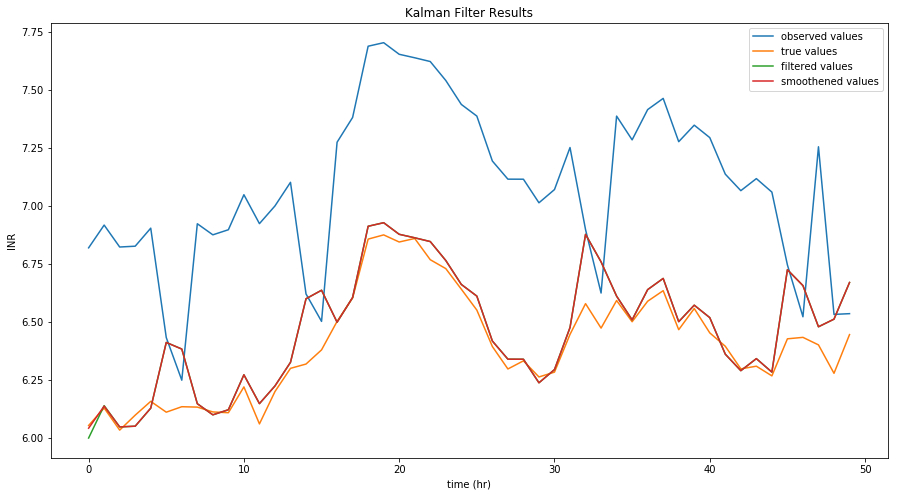

In [929]:
em = EM(model.y, model.X, model.c, 1, 1, 0, model.A.shape[0])
em.run_EM(1000)

In [930]:
em.sigma_1/em.sigma_2

138.09334595130133

In [931]:
model.noise_1/model.noise_2

10.0

### Last Observation Carry Forward

In [932]:
# assume the first observation is not nan and the data array is not entirely nan
def LBCF(data):
    filled = np.zeros(data.shape)
    for i, y in enumerate(data):
        if np.isnan(y):
            filled[i] = filled[i-1]
        else:
            filled[i] = y
    return filled

y_filled = LBCF(model.y)            

276 iterations before convergence
params: [-0.74547004 -0.89965358  0.77397352]
sigma_1: 0.021643389480609603
sigma_2: 0.00016049308139884033


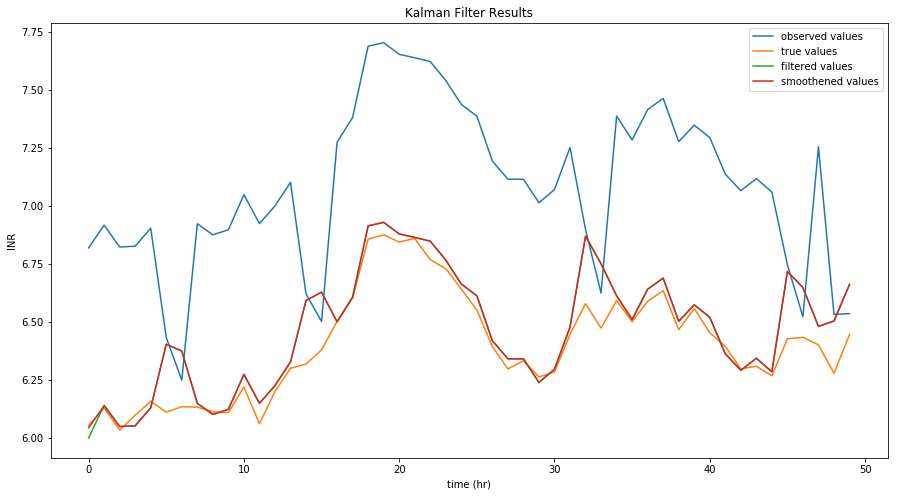

In [933]:
em_1 = EM(y_filled, model.X, model.c, 1, 1, 0, 2)
em_1.run_EM(1000)

### Notes on the current model

1. Identifying coefficients is still somewhat challenging (often off by a little)
2. When the coefficients are too small i.e. closer to the noise value, the model is unable to recover them.
3. The model has trouble identifying the noise values
4. The shift between the smoothened values and the true value is the difference between the estimated coefficient b and the true value of the coefficient. If the model underestimates, since y is the same for both underlying data generaing model and the estimating model, the estimated z would be larger than the true state value.  